In [1]:
import torch
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
import pandas as pd
from torchvision import datasets
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler


In [2]:
#images = "/home/bandyadkas/cellcyle/data/"
images = "/mnt/efs/woods_hole/bbbc_cellcycle/model_data/data/"

In [3]:
transform = {
        'train': transforms.Compose([
            #transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            #transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            #transforms.Resize([224,224]),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0), std=(1))
        ])
    }

In [4]:
all_images = datasets.ImageFolder(images,transform=transform['train'])
print(len(all_images))

32266


In [5]:
train_size = int(0.7 * len(all_images))
val_size = int(0.15 * len(all_images))
test_size = len(all_images) - (train_size + val_size)
print(train_size, val_size, test_size)
assert train_size + val_size + test_size == len(all_images)

22586 4839 4841


In [6]:
train_set, val_set, test_set = torch.utils.data.random_split(all_images, [train_size, val_size, test_size])
#train_set, val_set, test_set = torch.utils.data.random_split(all_images, [22538, 4829, 4831])

In [7]:
def _get_weights(subset,full_dataset):
    ys = np.array([y for _, y in subset])
    counts = np.bincount(ys)
    label_weights = 1.0 / counts
    weights = label_weights[ys]

    print("Number of images per class:")
    for c, n, w in zip(full_dataset.classes, counts, label_weights):
        print(f"\t{c}:\tn={n}\tweight={w}")
        
    return weights


In [8]:

train_weights = _get_weights(train_set,all_images)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))


Number of images per class:
	Anaphase:	n=9	weight=0.1111111111111111
	G1:	n=10016	weight=9.984025559105431e-05
	G2:	n=5988	weight=0.00016700066800267202
	Metaphase:	n=54	weight=0.018518518518518517
	Prophase:	n=433	weight=0.0023094688221709007
	S:	n=6067	weight=0.00016482610845557937
	Telophase:	n=19	weight=0.05263157894736842


In [9]:
train_loader = DataLoader(train_set, batch_size=8, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=8 , drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, drop_last=True, shuffle=True)

In [10]:
## Set up tensorboard
writer = SummaryWriter('/home/healeyh/cellcycle/runs/hmh_cellcycle_exp1/cellcycle_resnet18_discrete')

In [11]:
#!tensorboard --logdir=runs

In [12]:
resnet18_model = torchvision.models.resnet18(pretrained = False, progress  = True, num_classes=7)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)
print(f"Will use device {device} for training")

Will use device cuda for training


In [14]:
from tqdm import tqdm

def train(model,loss,train_dataloader):
    model.train()
    epoch_loss = 0
    num_batches = 0
    for x, y in tqdm(train_dataloader):

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()

        epoch_loss += l
        num_batches += 1

    return epoch_loss/num_batches

def evaluate(model, loss, dataloader):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):

            x, y = x.to(device), y.to(device)

            logits = model(x)
            val_loss = loss(logits,y)
            
            probs = torch.nn.Softmax(dim=1)(logits)
            predictions = torch.argmax(probs, dim=1)

            correct += int(torch.sum(predictions == y).cpu().detach().numpy())
            total += len(y)

        accuracy = correct/total

    return accuracy, val_loss

def validate(model,loss, validation_dataloader):
    '''Evaluate prediction accuracy on the validation dataset.'''
    
    model.eval()
    return evaluate(model,loss,validation_dataloader)

def test(model,loss,test_dataloader):
    '''Evaluate prediction accuracy on the test dataset.'''
    
    model.eval() 
    return evaluate(model, loss,test_dataloader)

In [15]:
step = 0
epochs = 200
for epoch in range(epochs+1):
    while step < epoch: 
    
        epoch_loss = train(resnet18_model,loss_fn,train_loader)
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
        validation_accuracy, validation_loss = validate(resnet18_model, loss_fn,val_loader)
        print(f"epoch {epoch}, validation accuracy={validation_accuracy}")
    
        writer.add_scalar('Loss/train', epoch_loss.cpu().detach().numpy(),step)      
        writer.add_scalar('Accuracy/validation', validation_accuracy,step)
        writer.add_scalar('Loss/validation', validation_loss.cpu().detach().numpy(),step)
        
        if step == 150:
            state = {
                'epoch': epoch,
                'state_dict': resnet18_model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            torch.save(state, "/mnt/efs/woods_hole/bbbc_cellcycle/classify_cellCycle_bandyadka/modelsave_resnet18.pth")
        
        step += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:47<00:00, 26.35it/s]


epoch 1, training loss=0.6362175345420837


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.29it/s]


epoch 1, validation accuracy=0.7311672185430463


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.73it/s]


epoch 2, training loss=0.42537686228752136


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.82it/s]


epoch 2, validation accuracy=0.6748758278145696


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.48it/s]


epoch 3, training loss=0.36315256357192993


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.30it/s]


epoch 3, validation accuracy=0.7363410596026491


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:49<00:00, 25.71it/s]


epoch 4, training loss=0.3163786828517914


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.07it/s]


epoch 4, validation accuracy=0.7493791390728477


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:50<00:00, 25.48it/s]


epoch 5, training loss=0.2975205183029175


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:49<00:00, 25.69it/s]


epoch 6, training loss=0.2762944996356964


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.13it/s]


epoch 6, validation accuracy=0.714817880794702


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:49<00:00, 25.76it/s]


epoch 7, training loss=0.2652188539505005


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 30.15it/s]


epoch 7, validation accuracy=0.7584850993377483


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:49<00:00, 25.81it/s]


epoch 8, training loss=0.24743330478668213


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.83it/s]


epoch 8, validation accuracy=0.7537251655629139


 32%|████████████████████████████▊                                                             | 903/2823 [00:35<01:14, 25.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:21<00:00, 28.42it/s]


epoch 16, validation accuracy=0.7547599337748344


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:55<00:00, 24.39it/s]


epoch 17, training loss=0.18457143008708954


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:22<00:00, 27.41it/s]


epoch 17, validation accuracy=0.7417218543046358


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:55<00:00, 24.52it/s]


epoch 18, training loss=0.17650920152664185


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:21<00:00, 28.02it/s]


epoch 18, validation accuracy=0.7510347682119205


 74%|█████████████████████████████████████████████████████████████████▍                       | 2075/2823 [01:25<00:30, 24.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:53<00:00, 24.97it/s]


epoch 20, training loss=0.15910397469997406


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.32it/s]


epoch 20, validation accuracy=0.7632450331125827


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:49<00:00, 25.82it/s]


epoch 21, training loss=0.15737487375736237


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.36it/s]


epoch 21, validation accuracy=0.757864238410596


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:50<00:00, 25.63it/s]


epoch 22, training loss=0.152971550822258


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.39it/s]


epoch 22, validation accuracy=0.7369619205298014


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:53<00:00, 24.93it/s]


epoch 23, training loss=0.14250671863555908


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 28.80it/s]


epoch 23, validation accuracy=0.7475165562913907


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:52<00:00, 25.01it/s]


epoch 24, training loss=0.13179093599319458


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:21<00:00, 28.49it/s]


epoch 24, validation accuracy=0.7419288079470199


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.41it/s]


epoch 25, training loss=0.12912367284297943


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.96it/s]


epoch 25, validation accuracy=0.7369619205298014


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.00it/s]


epoch 26, training loss=0.1227291151881218


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.14it/s]


epoch 26, validation accuracy=0.7481374172185431


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.88it/s]


epoch 27, training loss=0.11103881895542145


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.41it/s]


epoch 27, validation accuracy=0.7545529801324503


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.60it/s]


epoch 28, training loss=0.10627397894859314


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.38it/s]


epoch 28, validation accuracy=0.7437913907284768


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.81it/s]


epoch 29, training loss=0.1010919138789177


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.34it/s]


epoch 29, validation accuracy=0.7303394039735099


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.21it/s]


epoch 30, training loss=0.10170895606279373


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.78it/s]


epoch 30, validation accuracy=0.730546357615894


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.19it/s]


epoch 31, training loss=0.09635372459888458


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.28it/s]


epoch 31, validation accuracy=0.7549668874172185


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.62it/s]


epoch 32, training loss=0.08971191942691803


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.82it/s]


epoch 32, validation accuracy=0.7448261589403974


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.60it/s]


epoch 33, training loss=0.08434014022350311


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.89it/s]


epoch 33, validation accuracy=0.7406870860927153


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.94it/s]


epoch 34, training loss=0.08274222910404205


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.45it/s]


epoch 34, validation accuracy=0.7531043046357616


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.69it/s]


epoch 35, training loss=0.07243504375219345


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.49it/s]


epoch 35, validation accuracy=0.7580711920529801


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.74it/s]


epoch 36, training loss=0.07511970400810242


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.16it/s]


epoch 36, validation accuracy=0.7396523178807947


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.84it/s]


epoch 37, training loss=0.06922322511672974


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.97it/s]


epoch 37, validation accuracy=0.7278559602649006


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.58it/s]


epoch 38, training loss=0.06542234122753143


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.22it/s]


epoch 38, validation accuracy=0.7481374172185431


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.84it/s]


epoch 39, training loss=0.061037007719278336


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.66it/s]


epoch 39, validation accuracy=0.7384105960264901


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.13it/s]


epoch 40, training loss=0.058671556413173676


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.76it/s]


epoch 40, validation accuracy=0.7396523178807947


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.92it/s]


epoch 41, training loss=0.05495167523622513


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.92it/s]


epoch 41, validation accuracy=0.730546357615894


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.68it/s]


epoch 42, training loss=0.05467427894473076


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.80it/s]


epoch 42, validation accuracy=0.7415149006622517


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.67it/s]


epoch 43, training loss=0.05135989561676979


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.64it/s]


epoch 43, validation accuracy=0.7437913907284768


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.61it/s]


epoch 44, training loss=0.050692301243543625


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.23it/s]


epoch 44, validation accuracy=0.7398592715231788


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.67it/s]


epoch 45, training loss=0.04979504272341728


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.50it/s]


epoch 45, validation accuracy=0.7324089403973509


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.57it/s]


epoch 46, training loss=0.046571578830480576


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.69it/s]


epoch 46, validation accuracy=0.7429635761589404


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.60it/s]


epoch 47, training loss=0.040276966989040375


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.98it/s]


epoch 47, validation accuracy=0.7506208609271523


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.45it/s]


epoch 48, training loss=0.03997352346777916


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.73it/s]


epoch 48, validation accuracy=0.7319950331125827


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.96it/s]


epoch 49, training loss=0.04270560294389725


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.88it/s]


epoch 49, validation accuracy=0.7398592715231788


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.93it/s]


epoch 50, training loss=0.040401652455329895


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.17it/s]


epoch 50, validation accuracy=0.7322019867549668


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.45it/s]


epoch 51, training loss=0.038524746894836426


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.78it/s]


epoch 51, validation accuracy=0.7502069536423841


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.49it/s]


epoch 52, training loss=0.03457184135913849


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.81it/s]


epoch 52, validation accuracy=0.7462748344370861


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.60it/s]


epoch 53, training loss=0.03734511509537697


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.45it/s]


epoch 53, validation accuracy=0.7427566225165563


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.89it/s]


epoch 54, training loss=0.033915724605321884


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.34it/s]


epoch 54, validation accuracy=0.7398592715231788


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.88it/s]


epoch 55, training loss=0.03245924785733223


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.24it/s]


epoch 55, validation accuracy=0.7233029801324503


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.78it/s]


epoch 56, training loss=0.03588232770562172


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.31it/s]


epoch 56, validation accuracy=0.7311672185430463


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.84it/s]


epoch 57, training loss=0.033101752400398254


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.35it/s]


epoch 57, validation accuracy=0.7355132450331126


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.12it/s]


epoch 58, training loss=0.03186459466814995


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.07it/s]


epoch 58, validation accuracy=0.7348923841059603


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.22it/s]


epoch 59, training loss=0.03194950520992279


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.60it/s]


epoch 59, validation accuracy=0.7224751655629139


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.25it/s]


epoch 60, training loss=0.02922319993376732


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.61it/s]


epoch 60, validation accuracy=0.7516556291390728


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.94it/s]


epoch 61, training loss=0.031872618943452835


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.49it/s]


epoch 61, validation accuracy=0.7355132450331126


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.92it/s]


epoch 62, training loss=0.026798436418175697


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 29.77it/s]


epoch 62, validation accuracy=0.7303394039735099


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.80it/s]


epoch 63, training loss=0.028190402314066887


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.88it/s]


epoch 63, validation accuracy=0.7446192052980133


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.79it/s]


epoch 64, training loss=0.023689288645982742


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.16it/s]


epoch 64, validation accuracy=0.7545529801324503


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.56it/s]


epoch 65, training loss=0.0263399388641119


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.95it/s]


epoch 65, validation accuracy=0.7477235099337748


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.61it/s]


epoch 66, training loss=0.02459755726158619


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.19it/s]


epoch 66, validation accuracy=0.7489652317880795


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.51it/s]


epoch 67, training loss=0.027019796893000603


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.68it/s]


epoch 67, validation accuracy=0.7442052980132451


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.32it/s]


epoch 68, training loss=0.02551419287919998


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.50it/s]


epoch 68, validation accuracy=0.7427566225165563


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.04it/s]


epoch 69, training loss=0.024756386876106262


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.33it/s]


epoch 69, validation accuracy=0.7468956953642384


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.08it/s]


epoch 70, training loss=0.022838018834590912


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.85it/s]


epoch 70, validation accuracy=0.7473096026490066


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.02it/s]


epoch 71, training loss=0.023184752091765404


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.80it/s]


epoch 71, validation accuracy=0.753932119205298


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.21it/s]


epoch 72, training loss=0.023850848898291588


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.99it/s]


epoch 72, validation accuracy=0.7319950331125827


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.15it/s]


epoch 73, training loss=0.022932108491659164


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.91it/s]


epoch 73, validation accuracy=0.7425496688741722


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.11it/s]


epoch 74, training loss=0.02281280606985092


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.69it/s]


epoch 74, validation accuracy=0.7508278145695364


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 27.03it/s]


epoch 75, training loss=0.021340500563383102


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.38it/s]


epoch 75, validation accuracy=0.7495860927152318


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:46<00:00, 26.61it/s]


epoch 76, training loss=0.01937164179980755


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:20<00:00, 30.13it/s]


epoch 76, validation accuracy=0.7406870860927153


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:48<00:00, 26.09it/s]


epoch 77, training loss=0.023390214890241623


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 31.29it/s]


epoch 77, validation accuracy=0.742135761589404


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:44<00:00, 26.91it/s]


epoch 78, training loss=0.021180644631385803


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:19<00:00, 30.49it/s]


epoch 78, validation accuracy=0.7435844370860927


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:45<00:00, 26.67it/s]


epoch 79, training loss=0.02013564109802246


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 31.94it/s]


epoch 79, validation accuracy=0.7402731788079471


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.43it/s]


epoch 80, training loss=0.018179796636104584


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.61it/s]


epoch 80, validation accuracy=0.742135761589404


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.49it/s]


epoch 81, training loss=0.018832368776202202


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.16it/s]


epoch 81, validation accuracy=0.7456539735099338


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.53it/s]


epoch 82, training loss=0.018967404961586


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.73it/s]


epoch 82, validation accuracy=0.742135761589404


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.65it/s]


epoch 83, training loss=0.018928665667772293


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.57it/s]


epoch 83, validation accuracy=0.7386175496688742


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.50it/s]


epoch 84, training loss=0.017490316182374954


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.30it/s]


epoch 84, validation accuracy=0.7377897350993378


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.30it/s]


epoch 85, training loss=0.020018775016069412


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.01it/s]


epoch 85, validation accuracy=0.734271523178808


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.47it/s]


epoch 86, training loss=0.0205589197576046


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.57it/s]


epoch 86, validation accuracy=0.7481374172185431


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.47it/s]


epoch 87, training loss=0.017022399231791496


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.41it/s]


epoch 87, validation accuracy=0.7473096026490066


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.42it/s]


epoch 88, training loss=0.01750686764717102


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.20it/s]


epoch 88, validation accuracy=0.7398592715231788


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.38it/s]


epoch 89, training loss=0.017945444211363792


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.32it/s]


epoch 89, validation accuracy=0.7458609271523179


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.34it/s]


epoch 90, training loss=0.017504900693893433


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.14it/s]


epoch 90, validation accuracy=0.734271523178808


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.38it/s]


epoch 91, training loss=0.018049659207463264


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.24it/s]


epoch 91, validation accuracy=0.7437913907284768


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.38it/s]


epoch 92, training loss=0.016990039497613907


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.46it/s]


epoch 92, validation accuracy=0.7313741721854304


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.43it/s]


epoch 93, training loss=0.014470492489635944


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.68it/s]


epoch 93, validation accuracy=0.7431705298013245


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.44it/s]


epoch 94, training loss=0.01737666130065918


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.45it/s]


epoch 94, validation accuracy=0.7468956953642384


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.47it/s]


epoch 95, training loss=0.01422711368650198


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.34it/s]


epoch 95, validation accuracy=0.7541390728476821


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.24it/s]


epoch 96, training loss=0.017543205991387367


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.26it/s]


epoch 96, validation accuracy=0.7485513245033113


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.49it/s]


epoch 97, training loss=0.013626101426780224


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.49it/s]


epoch 97, validation accuracy=0.7423427152317881


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.39it/s]


epoch 98, training loss=0.01761833019554615


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.40it/s]


epoch 98, validation accuracy=0.7396523178807947


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.43it/s]


epoch 99, training loss=0.017999211326241493


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.33it/s]


epoch 99, validation accuracy=0.7524834437086093


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.36it/s]


epoch 100, training loss=0.012184547260403633


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.38it/s]


epoch 100, validation accuracy=0.7330298013245033


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.35it/s]


epoch 101, training loss=0.016663184389472008


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.47it/s]


epoch 101, validation accuracy=0.7462748344370861


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.37it/s]


epoch 102, training loss=0.01702253520488739


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.42it/s]


epoch 102, validation accuracy=0.7452400662251656


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.46it/s]


epoch 103, training loss=0.014102007262408733


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.51it/s]


epoch 103, validation accuracy=0.7365480132450332


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.41it/s]


epoch 104, training loss=0.013767262920737267


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.41it/s]


epoch 104, validation accuracy=0.7377897350993378


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.50it/s]


epoch 105, training loss=0.015126782469451427


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.64it/s]


epoch 105, validation accuracy=0.7406870860927153


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.30it/s]


epoch 106, training loss=0.013059171847999096


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.26it/s]


epoch 106, validation accuracy=0.7444122516556292


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.47it/s]


epoch 107, training loss=0.013136585243046284


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.34it/s]


epoch 107, validation accuracy=0.7330298013245033


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.45it/s]


epoch 108, training loss=0.01247453410178423


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.50it/s]


epoch 108, validation accuracy=0.7406870860927153


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.40it/s]


epoch 109, training loss=0.015365519560873508


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.61it/s]


epoch 109, validation accuracy=0.7442052980132451


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.44it/s]


epoch 110, training loss=0.012990090064704418


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.63it/s]


epoch 110, validation accuracy=0.7137831125827815


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.43it/s]


epoch 111, training loss=0.013855088502168655


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.57it/s]


epoch 111, validation accuracy=0.75


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.45it/s]


epoch 112, training loss=0.016886485740542412


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.62it/s]


epoch 112, validation accuracy=0.7406870860927153


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.35it/s]


epoch 113, training loss=0.012716220691800117


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.46it/s]


epoch 113, validation accuracy=0.7485513245033113


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.47it/s]


epoch 114, training loss=0.012459048070013523


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.67it/s]


epoch 114, validation accuracy=0.7365480132450332


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.34it/s]


epoch 115, training loss=0.01329828891903162


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:16<00:00, 36.58it/s]


epoch 115, validation accuracy=0.7535182119205298


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:39<00:00, 28.46it/s]


epoch 116, training loss=0.01262400858104229


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.58it/s]


epoch 116, validation accuracy=0.7485513245033113


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.40it/s]


epoch 117, training loss=0.011743118986487389


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.32it/s]


epoch 117, validation accuracy=0.7419288079470199


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.31it/s]


epoch 118, training loss=0.013800286687910557


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.85it/s]


epoch 118, validation accuracy=0.7444122516556292


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.46it/s]


epoch 119, training loss=0.012337258085608482


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.56it/s]


epoch 119, validation accuracy=0.7400662251655629


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.22it/s]


epoch 120, training loss=0.013237315230071545


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.80it/s]


epoch 120, validation accuracy=0.7454470198675497


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.44it/s]


epoch 121, training loss=0.01278406661003828


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.74it/s]


epoch 121, validation accuracy=0.7489652317880795


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:41<00:00, 27.68it/s]


epoch 122, training loss=0.011501246131956577


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:15<00:00, 37.99it/s]


epoch 122, validation accuracy=0.7454470198675497


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:39<00:00, 28.35it/s]


epoch 123, training loss=0.011571181938052177


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.43it/s]


epoch 123, validation accuracy=0.7489652317880795


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:43<00:00, 27.40it/s]


epoch 124, training loss=0.011519352905452251


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.51it/s]


epoch 124, validation accuracy=0.7423427152317881


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.47it/s]


epoch 125, training loss=0.011745339259505272


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.44it/s]


epoch 125, validation accuracy=0.7483443708609272


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.60it/s]


epoch 126, training loss=0.014561012387275696


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.33it/s]


epoch 126, validation accuracy=0.7303394039735099


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:38<00:00, 28.70it/s]


epoch 127, training loss=0.01012242492288351


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:16<00:00, 37.20it/s]


epoch 127, validation accuracy=0.7450331125827815


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:41<00:00, 27.68it/s]


epoch 128, training loss=0.010165056213736534


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.43it/s]


epoch 128, validation accuracy=0.7446192052980133


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:41<00:00, 27.81it/s]


epoch 129, training loss=0.010867055505514145


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.89it/s]


epoch 129, validation accuracy=0.7448261589403974


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:41<00:00, 27.72it/s]


epoch 130, training loss=0.011102608405053616


100%|███████████████████████████████████████████████████████████████████████████████████████████| 604/604 [00:18<00:00, 32.78it/s]


epoch 130, validation accuracy=0.7299254966887417


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2823/2823 [01:42<00:00, 27.41it/s]


epoch 131, training loss=0.009969615377485752


  5%|████▋                                                                                       | 31/604 [00:00<00:17, 32.93it/s]


KeyboardInterrupt: 

In [ ]:
#load_model = torch.load("/mnt/efs/woods_hole/bbbc_cellcycle/classify_cellCycle_bandyadka/modelsave.pth")

In [17]:
test_accuracy, test_loss = test(resnet18_model,loss_fn,test_loader)
print(f"final test accuracy: {test_accuracy}")
writer.add_scalar('Accuracy/test', test_accuracy)
writer.add_scalar('Loss/test', test_loss.cpu().detach().numpy(),step)
        


100%|███████████████████████████████████████████████████████████████████████████████████████████| 605/605 [00:18<00:00, 32.01it/s]

final test accuracy: 0.740909090909091


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# predict the test dataset
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None].cuda()
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)
    
    return np.array(dataset_prediction), np.array(dataset_groundtruth)
            

In [44]:
import pandas as pd
# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ["0", "1", "2", "3", "4", "5", "6"]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    x_axis_labels = ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase'] # labels for x-axis
    y_axis_labels = ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase'] # labels for y-axis
# create seabvorn heatmap with required labels
    #sns.heatmap(flights_df, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="viridis")
    ax.set_title(title)

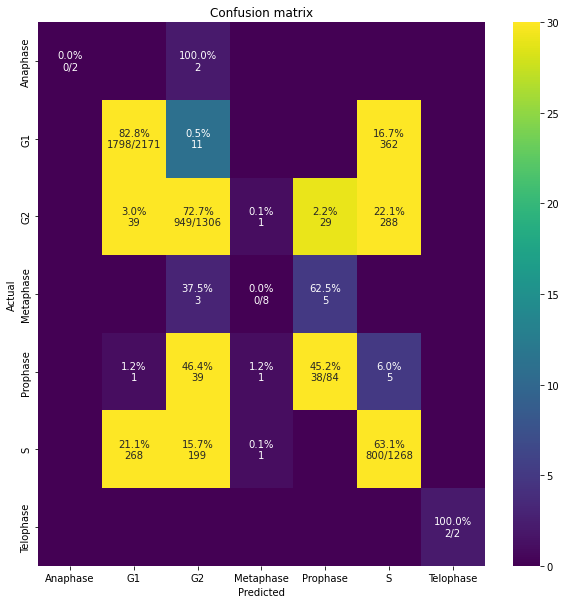

In [45]:
y_pred, y_true = predict(resnet18_model.cuda(), test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

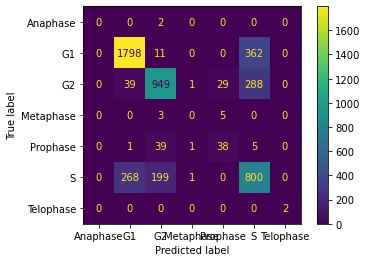

In [38]:
import sklearn
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=all_images.classes)
disp.plot()
plt.show()

## Integrated Gradients Exploration

In [26]:
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import numpy as np

test_pred, test_true = predict(resnet18_model.cuda(), test_set)


def visualize_ig(idx, 
                 _train_dataset=train_set, 
                 _test_dataset=test_set):
    
    #test_pred, test_true = predict1(resnet18.cuda(), _test_dataset[idx])
    
    # Get corresponding input and target tensors:
    input_tensor = _test_dataset[idx][0].unsqueeze(0)
    input_tensor.requires_grad = True
    target = _test_dataset[idx][1]
    
    # We will use the IntegratedGradients algorithm:
    algorithm = IntegratedGradients(resnet18_model.cpu())
    
    # First we clear the gradients from the model:
    resnet18_model.zero_grad()
    
    # Run attribution:
    attr_ig, delta = algorithm.attribute(input_tensor,
                                          target=target,
                                          baselines=input_tensor * 0,
                                          return_convergence_delta=True
                                        )
    
    # Integrated Gradients:
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    
    # Original image:
    original_image = np.transpose((_test_dataset[idx][0].detach().numpy() * 0.5) + 0.5, (1, 2, 0))
    
    #print("Annotated Stage", _test_dataset[idx][1])
    print("Annotated Stage", test_true[idx])
    plt.imshow(original_image)
    
    
    print("Predicted Stage", test_pred[idx])


    # This visualises the attribution of labels to 
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients")

Annotated Stage 1
Predicted Stage 5


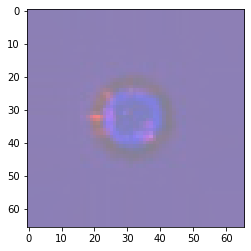

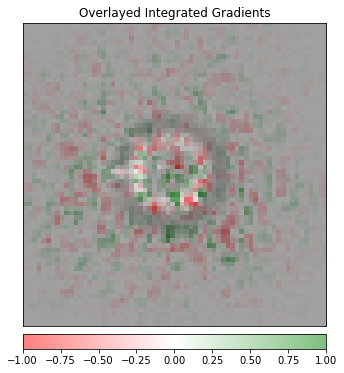

In [27]:
visualize_ig(0)

Annotated Stage 1
Predicted Stage 1


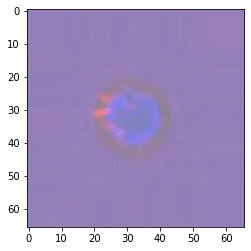

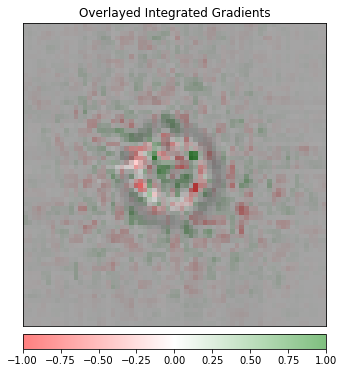

In [28]:
visualize_ig(8)

Annotated Stage 2
Predicted Stage 5


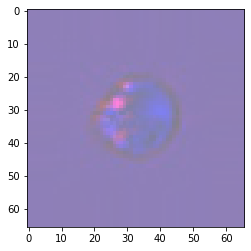

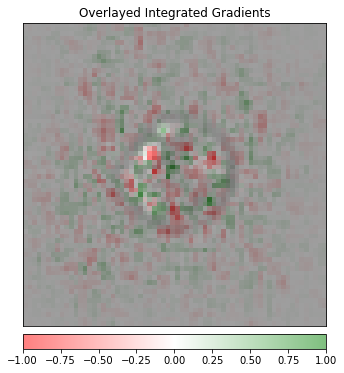

In [29]:
visualize_ig(20)

Annotated Stage 2
Predicted Stage 2


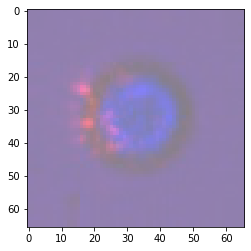

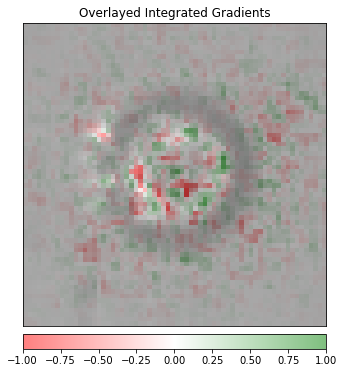

In [49]:
visualize_ig(390)

Annotated Stage 2
Predicted Stage 2


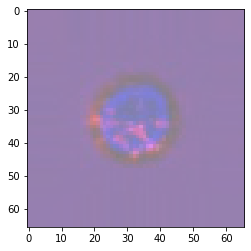

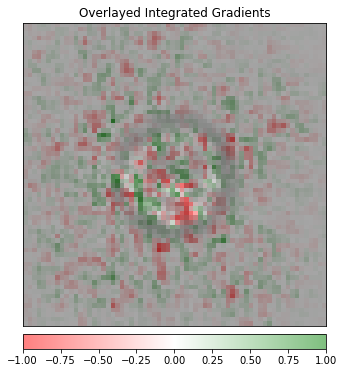

In [57]:
visualize_ig(398)